**Introduction: Predicting UPDRS Motor Score Using Multi-Modal Data: An Exploration of Machine Learning Models**

**Experiment 3**

In this experiment, we aimed to predict UPDRS motor scores utilizing multi-modal data. Building upon previously selected features, we performed further feature engineering by creating novel interaction terms such as the Striatal-Entorhinal Network Interaction, Asymmetry-Weighted Striatal Score, White Matter Integrity Index, Age-Adjusted Striatal Binding (Nonlinear), and Ventricular Effect Score.

We then conducted a Randomized Search to find optimal hyperparameters for a Random Forest Regressor model. This refined model achieved promising results on the test set, with a Mean Absolute Error (MAE) of **5.720**, a Mean Squared Error (MSE) of **55.963**, a Root Mean Squared Error (RMSE) of **7.481**, and an R² of **0.586**. These metrics suggest a performance approaching clinical utility.

Subsequently, we explored the application of a shallow Artificial Neural Network (ANN) with early stopping. The ANN model yielded an MAE of **6.985** and an R² of **0.411** on the test set. In this experiment, the Random Forest model demonstrated superior performance compared to the shallow ANN.

We hypothesize that further improvements to model performance, potentially reaching real clinical utility, could be achieved through the inclusion of additional clinically relevant features, more extensive hyperparameter tuning, and further sophisticated feature engineering techniques. Future work could focus on these areas to enhance the predictive capability of the models.

In [27]:
import pandas as pd
import numpy as np

In [29]:

df = pd.read_csv("final_df_cleaned.csv")

In [30]:
# Step 1: Drop irrelevant columns
drop_cols = ['PATNO', 'NHY', 'EVENT_ID_y']

df = df.drop(columns=drop_cols)

print("After dropping irrelevant columns:")
print(df.shape)
print(df.columns)

After dropping irrelevant columns:
(1716, 106)
Index(['SEX', 'AGE', 'Brain_Stem', 'Right_choroid_plexus',
       'Right_Cerebellum_White_Matter', 'Left_Cerebellum_Cortex',
       'Left_choroid_plexus', 'Left_Pallidum', 'Left_Thalamus',
       'Right_VentralDC',
       ...
       'Putamen_Total', 'Caudate_Total', 'Putamen_Asym', 'Caudate_Asym',
       'CortexVol_norm', 'TotalGrayVol_norm', 'Hippocampus_Total_norm',
       'Amygdala_Total_norm', 'Caudate_Total_norm', 'Putamen_Total_norm'],
      dtype='object', length=106)


In [31]:
y = df['NP3TOT']

In [32]:
selected_features = ['AGE', 'Left_choroid_plexus', 'Left_Accumbens_area',
       'lhCerebralWhiteMatterVol', 'CSF', 'lh_entorhinal', 'lh_middletemporal',
       'lh_temporalpole', 'lh_insula', 'rh_bankssts', 'rh_entorhinal',
       'rh_lateraloccipital', 'rh_parahippocampal', 'rh_parsorbitalis',
       'rh_pericalcarine', 'rh_rostralanteriorcingulate',
       'rh_rostralmiddlefrontal', 'rh_insula', 'Putamen_Total',
       'Caudate_Total', 'Putamen_Asym', 'Caudate_Asym', 'TotalGrayVol_norm',
       'Hippocampus_Total_norm', 'Putamen_Total_norm']

In [33]:
X_selected = df[selected_features].copy() # Create a copy to avoid SettingWithCopyWarning

In [34]:
X_selected.head()

,AGE,Left_choroid_plexus,Left_Accumbens_area,lhCerebralWhiteMatterVol,CSF,lh_entorhinal,lh_middletemporal,lh_temporalpole,lh_insula,rh_bankssts,...,rh_rostralanteriorcingulate,rh_rostralmiddlefrontal,rh_insula,Putamen_Total,Caudate_Total,Putamen_Asym,Caudate_Asym,TotalGrayVol_norm,Hippocampus_Total_norm,Putamen_Total_norm
0,69.1,747.9,160.4,248312.0,1039.0,2.805,2.271,2.954,2.751,2.752,...,2.848,2.234,2.848,5.57,6.42,-0.055655,0.068536,0.380586,0.005046,0.005288
1,65.1,716.5,333.4,279750.0,1481.8,3.539,2.719,3.715,2.989,2.391,...,2.520,2.064,2.756,1.45,3.92,-0.103448,-0.020408,0.378124,0.005145,0.007797
2,67.6,495.2,363.0,213644.0,835.3,3.771,2.976,4.115,3.072,2.690,...,2.515,2.359,3.040,2.79,6.64,0.275986,0.120482,0.419209,0.005184,0.007759
3,56.6,682.2,331.3,252510.0,1235.7,3.922,2.660,3.820,2.954,2.684,...,2.544,2.291,2.909,1.79,6.17,-0.240223,-0.176661,0.388823,0.005995,0.006880
4,59.3,358.6,396.3,268029.0,851.9,3.494,2.682,3.114,2.860,2.756,...,2.476,2.254,2.929,6.51,10.39,-0.087558,0.020212,0.382852,0.005141,0.006585


In [35]:
X_selected.shape

(1716, 25)

In [36]:
import numpy as np

# Create a copy of X_selected before adding new columns to avoid SettingWithCopyWarning
X_selected = X_selected.copy()

# Step 1: Striatal-Entorhinal Network Interaction - Ratio of Putamen volume to Entorhinal cortical thickness
X_selected['Putamen_Entorhinal_Ratio'] = X_selected['Putamen_Total'] / (X_selected['lh_entorhinal'] + 1e-6) # Added small epsilon to prevent division by zero

# 2. Asymmetry-Weighted Striatal Score - Putamen volume weighted by its asymmetry
X_selected['Asym_Striatal_Score'] = X_selected['Putamen_Total'] * (1 + abs(X_selected['Putamen_Asym']))

# 3. White Matter Integrity Index - Ratio of cerebral white matter volume to normalized total gray matter volume
X_selected['WM_Integrity'] = X_selected['lhCerebralWhiteMatterVol'] / X_selected['TotalGrayVol_norm']

# 4. Age-Adjusted Striatal Binding (Nonlinear) - Putamen volume adjusted for age using a cubic root transformation
X_selected['Age_Adjusted_Putamen'] = X_selected['Putamen_Total'] / (X_selected['AGE'] ** 0.33)

# 5. Ventricular Effect Score (if CSF represents ventricular volume) - Interaction between CSF volume and age
X_selected['Ventricular_Effect'] = X_selected['CSF'] * X_selected['AGE']

In [37]:
X_selected.shape

(1716, 30)

In [38]:
from sklearn.model_selection import train_test_split

# y should be your target vector (UPDRS scores)
X_train, X_test, y_train, y_test = train_test_split(
    X_selected,
    y,
    test_size=0.2,
    random_state=42,
    stratify=pd.qcut(y, q=3)  # Stratify by UPDRS severity
)

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define random distributions for hyperparameters
param_dist = {
    'n_estimators': [100, 300],  # Number of trees in the forest
    'max_depth': [7, 9, None],   # Maximum depth of the tree
    'min_samples_split': [2, 5], # Minimum number of samples required to split an internal node
    'max_features': [0.6, 'sqrt'] # Number of features to consider when looking for the best split
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# RandomizedSearchCV: search for the best hyperparameters using cross-validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=3,  # Number of folds in cross-validation
    scoring='neg_mean_absolute_error', # Scoring metric to evaluate the models
    random_state=42,
    n_jobs=-1 # Use all available cores
)

# Fit the random search model
random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_ # Get the best model found by random search

In [40]:
best_rf

RandomForestRegressor(max_depth=7, max_features=0.6, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [41]:
# Upweight clinically critical UPDRS range (20-40) to give more importance to these instances during training
sample_weight = np.where(
    (y_train >= 20) & (y_train <= 40),
    1.5,  # 50% higher weight for samples in this range
    1.0   # Default weight for other samples
)
# Fit the best Random Forest model with sample weights
best_rf.fit(X_train, y_train, sample_weight=sample_weight)

RandomForestRegressor(max_depth=7, max_features=0.6, n_estimators=300,
                      n_jobs=-1, random_state=42)

MAE: 5.720
MSE: 55.963
RMSE: 7.481
R²: 0.586


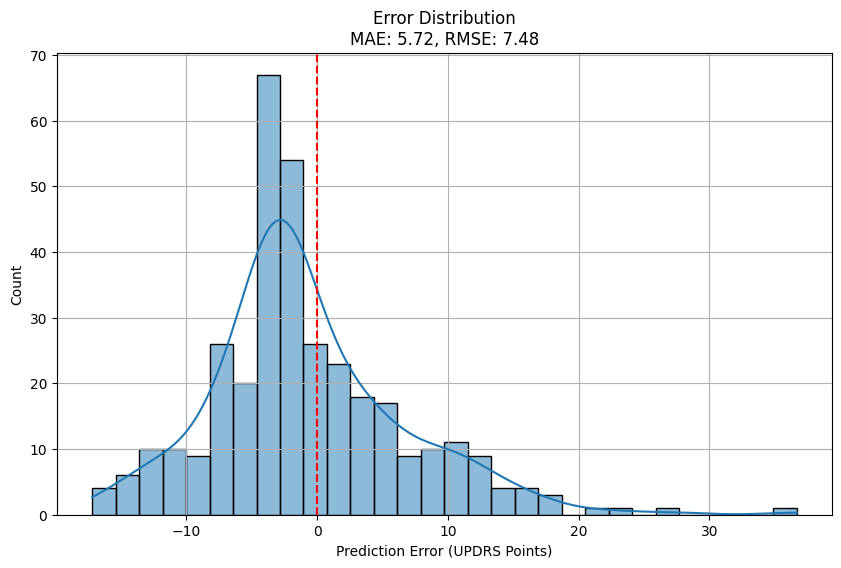

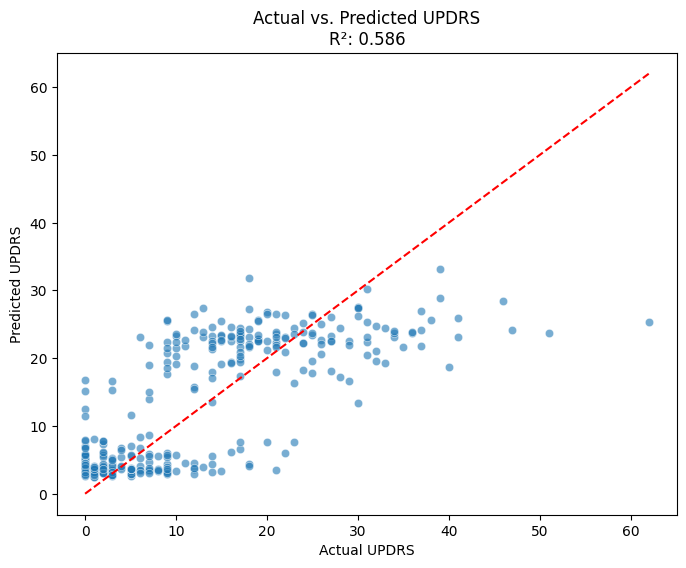

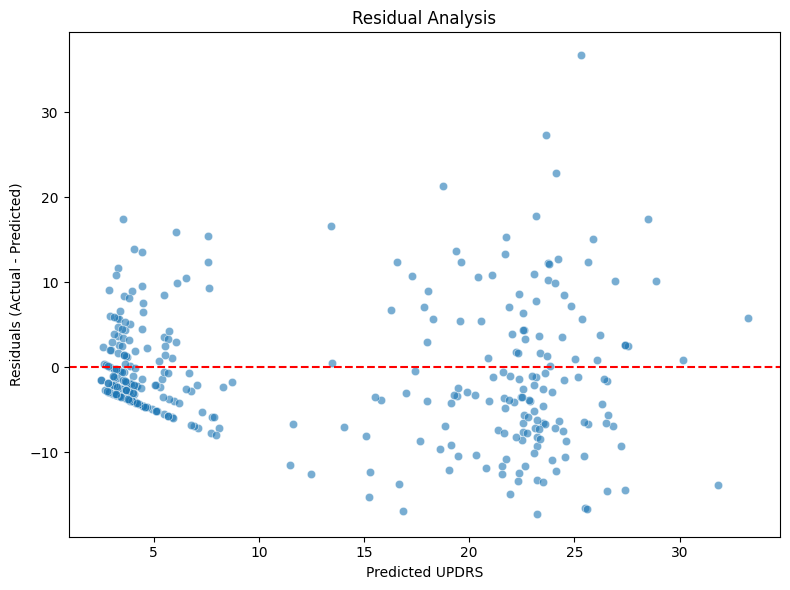

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions on the test set
y_pred = best_rf.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print comprehensive results
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

# Residual analysis
residuals = y_test - y_pred

# 1. Error Distribution Plot - Visualize the distribution of prediction errors
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='r', linestyle='--') # Add a vertical line at zero error
plt.xlabel("Prediction Error (UPDRS Points)")
plt.title(f"Error Distribution\nMAE: {mae:.2f}, RMSE: {rmse:.2f}")
plt.grid(True)

# 2. Actual vs. Predicted Plot - Compare actual UPDRS scores to predicted scores
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Add a line representing perfect prediction
plt.xlabel("Actual UPDRS")
plt.ylabel("Predicted UPDRS")
plt.title(f"Actual vs. Predicted UPDRS\nR²: {r2:.3f}")

# 3. Residuals vs. Predicted - Check for patterns in residuals based on predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--') # Add a horizontal line at zero residual
plt.xlabel("Predicted UPDRS")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Analysis")

plt.tight_layout()
plt.show()

In [43]:
# 6. Feature importance analysis
feat_imp = pd.Series(best_rf.feature_importances_, index=X_train.columns)
print("\nTop Features:")
print(feat_imp.sort_values(ascending=False).head(10))


Top Features:
Putamen_Total               0.357817
Age_Adjusted_Putamen        0.101558
Caudate_Total               0.098390
Asym_Striatal_Score         0.080424
Putamen_Asym                0.079576
Caudate_Asym                0.028945
Putamen_Entorhinal_Ratio    0.021773
lh_insula                   0.013215
AGE                         0.012982
lh_temporalpole             0.012932
dtype: float64


In [44]:
import shap

In [45]:
explainer = shap.Explainer(best_rf, X_train)
shap_values = explainer(X_test, check_additivity=False)

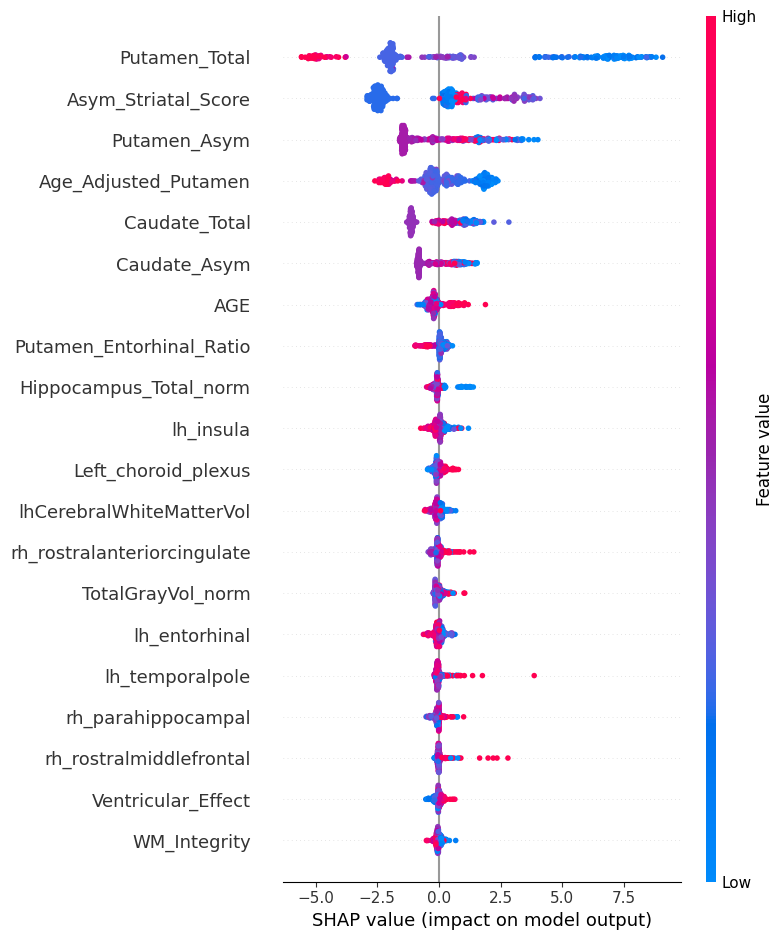

In [46]:
shap.summary_plot(shap_values, X_test)

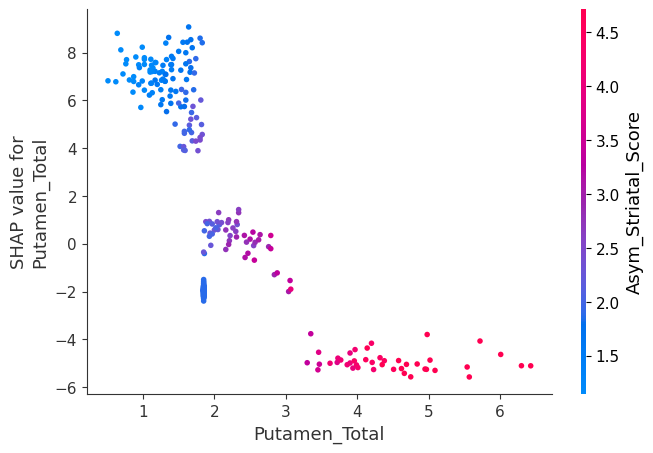

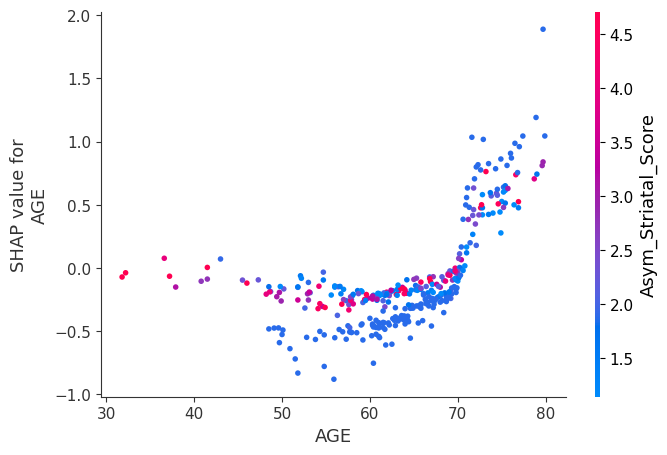

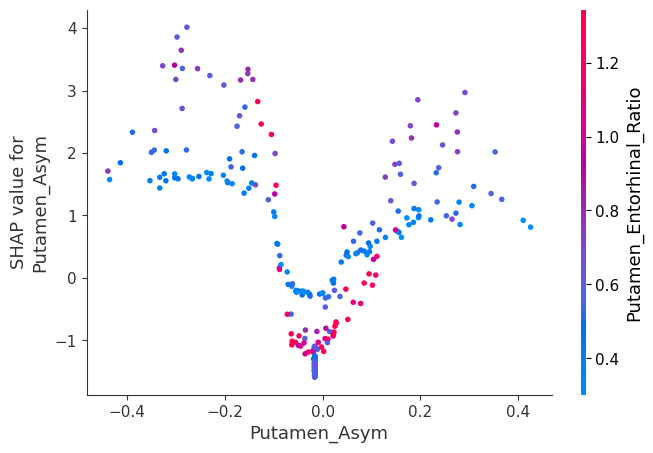

In [47]:
shap.dependence_plot('Putamen_Total', shap_values.values, X_test)
shap.dependence_plot('AGE', shap_values.values, X_test)
shap.dependence_plot('Putamen_Asym', shap_values.values, X_test)

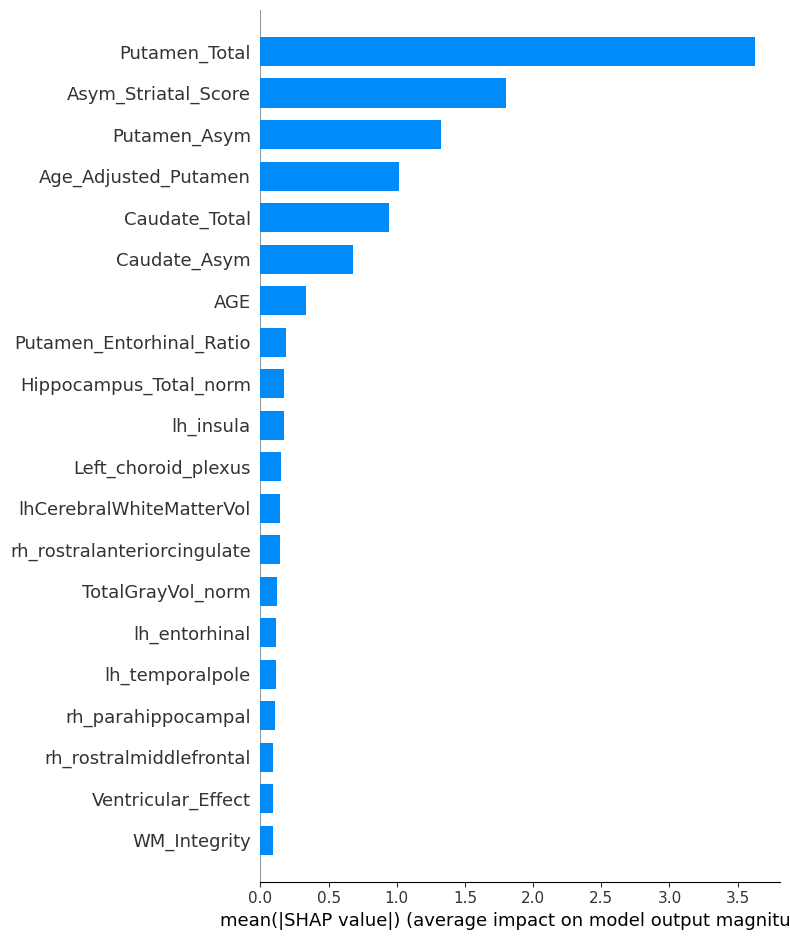

In [48]:
shap.summary_plot(shap_values, X_test, plot_type="bar")